In [127]:
import json
from pathlib import Path
from collections import defaultdict
import pathlib
import numpy as np
import re

In [128]:
EVAL_DIR = "/workspace/chunky-experiments/experiments/2025-06-22_19-25-13_7B_sen_len_4_opts/"

In [129]:
def parse_experiment_name(exp_name: str) -> tuple[tuple[str, str], tuple[str, str]]:
    """
    Parse experiment names of the form "4_en_short_city_de_long_disease"
    into structured format: ((english_domain, english_length), (german_domain, german_length))
    
    Args:
        exp_name: String like "4_en_short_city_de_long_disease"
        
    Returns:
        Tuple of ((english_domain, english_length), (german_domain, german_length))
        Example: (("city", "short"), ("disease", "long"))
    """
    # Pattern to match: number_en_length_domain_de_length_domain
    pattern = r'\d+_en_(short|long)_(\w+)_de_(short|long)_(\w+)'
    match = re.match(pattern, exp_name)
    
    if not match:
        raise ValueError(f"Invalid experiment name format: {exp_name}")
    
    english_length, english_domain, german_length, german_domain = match.groups()
    
    return ((english_domain, english_length), (german_domain, german_length))

def get_lengths(data):
    lengths = defaultdict(list)

    for item in data:
        gen_text = item["generation"][len(item["input"]):]

        lengths[(item["domain"], item["language"])].append(len(gen_text))
    
    return lengths

def read_exp_dir_results(exp_dir: pathlib.Path):
    results_file = exp_dir / "validation_data" / "results.jsonl"
    with open(results_file, "r") as f:
        data = []

        for line in f:
            info = json.loads(line)
            info["generation"] = info["output"][0]["generated_text"]
            data.append(info)
    
    return data


def read_all_experiments(eval_dir: pathlib.Path):
    experiments_avg_length_train_setting_to_eval_setting = defaultdict(list)

    for exp_dir in sorted(Path(eval_dir).glob("*")):
        ((english_domain, english_length), (german_domain, german_length)) = parse_experiment_name(exp_dir.name)

        data = read_exp_dir_results(exp_dir)
        lengths = get_lengths(data)
        
        experiments_avg_length_train_setting_to_eval_setting[
            ("en", english_domain, english_length)
        ] = {
            k: np.mean(v) for k, v in lengths.items()
        }

        experiments_avg_length_train_setting_to_eval_setting[
            ("de", german_domain, german_length)
        ] = {
            k: np.mean(v) for k, v in lengths.items()
        }
    return experiments_avg_length_train_setting_to_eval_setting


In [137]:
def swap_language(language: str) -> str:
    return "en" if language == "de" else "de"

def swap_length(length: str) -> str:
    return "short" if length == "long" else "long"

def swap_domain(domain: str) -> str:
    return "city" if domain == "disease" else "disease"

def compute_matrics(experiments_avg_length_train_setting_to_eval_setting: dict):
    all_ratios = []
    in_domain_output_lengths = {}

    for (language, domain, length), mean_lengths in experiments_avg_length_train_setting_to_eval_setting.items():
        in_domain_output_lengths[language, domain, length] = mean_lengths[(domain, language)]


    for (language, domain, length), mean_lengths in experiments_avg_length_train_setting_to_eval_setting.items():
        generalization_domain = swap_domain(domain)
        generalized_length = mean_lengths[(generalization_domain, language)]

        target_length = experiments_avg_length_train_setting_to_eval_setting[
            (language, generalization_domain, swap_length(length))
        ][(generalization_domain, language)]

        in_domain_length = mean_lengths[(domain, language)]
        in_domain_length_other_length = experiments_avg_length_train_setting_to_eval_setting[
            language,
            domain,
            swap_length(length)
        ][(domain, language)]

        length_gap = target_length - generalized_length
        expected_length_gap = in_domain_length - in_domain_length_other_length
        length_gap_ratio = abs(expected_length_gap) / abs(length_gap)

        change_in_length = abs(generalized_length - in_domain_length)
        #length_gap_ratio = abs(length_gap) / abs(non_generalized_length_long - non_generalized_length_short)

        all_ratios.append({"language": language, "length_gap_ratio": length_gap_ratio, "abs_length_gap": abs(length_gap), "change_in_length": change_in_length})

    df_ratios = pd.DataFrame(all_ratios)
    return df_ratios

In [145]:
def get_metrics_from_folder(folder: pathlib.Path):
    experiment_length = read_all_experiments(folder)
    return compute_matrics(experiment_length)

per_model_metrics = {}
for model_name, eval_dir in [
    ("70B", "/workspace/chunky-experiments/experiments/2025-06-22_19-25-13_7B_sen_len_4_opts/"),
    ("1.7B", "/workspace/chunky-experiments/experiments_sentences_scaling/2025-06-22_23-01_qwen1.7b-sentence/"),
    ("0.6B", "/workspace/chunky-experiments/experiments_sentences_scaling/2025-06-22_21-42_sweep/"),
]:
    per_model_metrics[model_name] = get_metrics_from_folder(eval_dir)

#print(per_model_metrics)
#concat to one dataframe with key as additional column
df_ratios = pd.concat(per_model_metrics.values(), keys=per_model_metrics.keys(), names=["model"])
print(df_ratios.groupby(["model", "language"]).mean())

                length_gap_ratio  abs_length_gap  change_in_length
model language                                                    
0.6B  de                0.350568       38.773715         34.776285
      en                0.147101       66.425000        122.140385
1.7B  de                0.465524       35.016652         35.016652
      en                0.425469       58.442949        154.587821
70B   de                0.138494      166.430239        166.430239
      en                0.105261      153.622306        155.788254


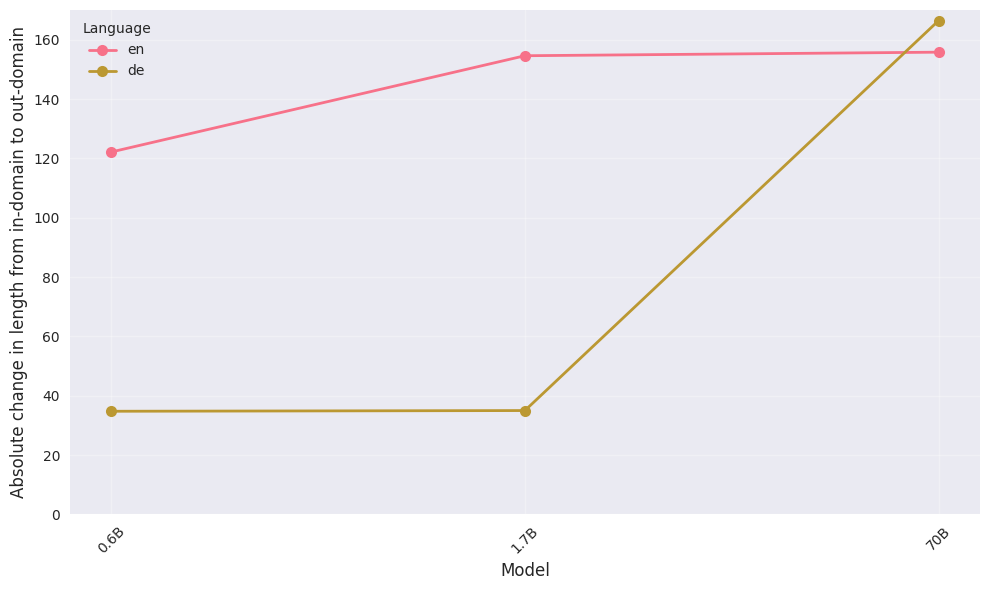

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Group by model and language, then plot
for language in df_ratios['language'].unique():
    language_data = df_ratios[df_ratios['language'] == language]
    model_means = language_data.groupby('model')['change_in_length'].mean()
    
    ax.plot(model_means.index, model_means.values, 
            marker='o', linewidth=2, markersize=8, 
            label=language)

# Customize the plot
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Absolute change in length from in-domain to out-domain', fontsize=12)
#ax.set_title('Change in Length by Model and Language', fontsize=14)
ax.legend(title='Language', fontsize=10)
ax.grid(True, alpha=0.3)

#start y axis at 0
ax.set_ylim(0, 170)

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
